In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns
import re

## 异常值全部替换为Nan，完成特征选择后再移含除异常值的sample，以最大程度保留样本

In [178]:
cancer_data = pd.read_csv('../../data/cancer_data_v4.csv')
cancer_data.drop(['MONO%', 'GGT'], axis=1, inplace=True)

In [179]:
cancer_data

,A=male B=female,Age_group,ID,"A=Case, B=Control",Origin,Pattern,Age,Smoke,RBC,HGB,...,UA,TG,TCH,HDL-C,LDL-C,ALP,CK,LDH-L,HBDH,T-CEA
0,B,Y,1,A,A,A,41,0.0,3.78,122.0,...,250.0,0.53,3.86,1.99,1.67,47.0,38.0,156.0,118.0,1.740
1,A,Y,100,A,A,A,35,0.0,5.53,169.0,...,266.0,1.23,6.60,2.49,3.85,43.0,23.0,191.0,159.0,1.985
2,A,Y,1000,A,A,A,50,0.0,4.04,120.0,...,285.0,0.93,4.22,1.12,2.96,66.0,60.0,211.0,166.0,3.330
3,B,Y,1007,A,A,A,50,200.0,4.14,131.0,...,270.0,1.76,3.97,1.47,2.20,58.0,64.0,227.0,173.0,0.760
4,A,Y,1008,A,A,A,51,400.0,4.54,139.0,...,233.0,1.27,3.55,1.10,2.13,88.0,51.0,159.0,146.0,1.985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7787,A,M,2489054,B,C,O,60,25.0,4.96,161.0,...,425.0,1.82,5.39,1.35,3.40,94.0,96.0,159.0,119.0,1.340
7788,A,Y,2491728,B,C,O,48,0.0,5.35,174.0,...,263.0,0.97,5.22,1.11,3.71,60.0,76.0,164.0,129.0,0.970
7789,A,M,2491799,B,C,O,56,0.0,6.36,129.0,...,295.0,1.19,5.91,1.39,4.03,124.0,38.0,128.0,112.0,1.380
7790,B,M,509610,B,C,O,59,25.0,5.03,147.0,...,243.0,0.71,5.39,1.83,2.88,71.0,129.0,273.0,232.0,3.880


## 中位数填充

In [69]:
for fea in cancer_data.columns[6:]:
    median = cancer_data.groupby(['Age_group', 'A=male B=female'])[fea].median()
    cancer_data.set_index(['Age_group', 'A=male B=female'], inplace=True)
    cancer_data[fea].fillna(median, inplace=True)
    cancer_data.reset_index(inplace=True)

In [71]:
X, y = cancer_data.loc[:,'Age':], cancer_data['A=Case, B=Control']

## 过滤思想进行特征选择

In [87]:
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif

### 卡方

In [147]:
fea_selc_chi = SelectKBest(score_func=chi2, k='all')
fea_selc_chi.fit(X,y)

SelectKBest(k='all', score_func=<function chi2 at 0x000001D6872920D0>)

In [150]:
chi_fea = pd.DataFrame({'Feature_Chi2':X.columns, 'Score':fea_selc_chi.scores_, 'P-val':fea_selc_chi.pvalues_ })
chi_fea.sort_values(by='Score', ascending=False, inplace=True)
print(chi_fea)
chi_fea = list(chi_fea['Feature_Chi2'])[:20]

   Feature_Chi2         Score          P-val
0         Smoke  1.343945e+06   0.000000e+00
7        RDW-CV  6.890217e+04   0.000000e+00
8        RDW-SD  6.529138e+04   0.000000e+00
40           CK  4.842219e+04   0.000000e+00
33           UA  3.403951e+04   0.000000e+00
43        T-CEA  7.273424e+03   0.000000e+00
12         LYM%  6.582449e+03   0.000000e+00
2           HGB  5.778084e+03   0.000000e+00
42         HBDH  4.280579e+03   0.000000e+00
41        LDH-L  3.897758e+03   0.000000e+00
26          ALB  3.203077e+03   0.000000e+00
38          ALP  2.815033e+03   0.000000e+00
11        NEUT%  2.587764e+03   0.000000e+00
20         TBIL  2.458428e+03   0.000000e+00
9           PLT  2.187253e+03   0.000000e+00
22         IBIL  2.156151e+03   0.000000e+00
25           TP  1.410537e+03  1.078216e-308
15         NEUT  9.405987e+02  1.466773e-206
10          WBC  4.345579e+02   1.655313e-96
21         DBIL  4.180635e+02   6.440884e-93
14        BASO%  1.760448e+02   3.540447e-40
39        

### 互信息

In [89]:
fea_selc_info = SelectKBest(score_func=mutual_info_classif, k='all')
fea_selc_info.fit(X,y)

SelectKBest(k='all',
            score_func=<function mutual_info_classif at 0x000001D6875E9CA0>)

In [151]:
info_fea = pd.DataFrame({'Feature_Info':X.columns, 'Score':fea_selc_info.scores_ })
info_fea.sort_values(by='Score', ascending=False, inplace=True)
print(info_fea)
info_fea = list(info_fea['Feature_Info'])[:20]

   Feature_Info     Score
7        RDW-CV  0.692895
8        RDW-SD  0.692895
31           Cr  0.428366
30          BUN  0.406017
26          ALB  0.346332
43        T-CEA  0.229737
0         Smoke  0.226084
40           CK  0.198462
25           TP  0.189230
2           HGB  0.174634
3           HCT  0.161085
28          A/G  0.158225
12         LYM%  0.138638
11        NEUT%  0.114563
22         IBIL  0.102164
33           UA  0.099485
1           RBC  0.095477
15         NEUT  0.093809
20         TBIL  0.092408
16        LYMPH  0.091020
14        BASO%  0.079668
5           MCH  0.072234
17         MONO  0.063556
42         HBDH  0.054229
41        LDH-L  0.052689
10          WBC  0.050218
35          TCH  0.048264
21         DBIL  0.048069
32   Cystatin-C  0.047020
19         BASO  0.045807
37        LDL-C  0.036509
18           EO  0.035121
4          MCV   0.034062
34           TG  0.029097
38          ALP  0.028105
29          GLU  0.027244
9           PLT  0.025550
6         MC

## 包裹思想进行特征选择：考虑在训练阶段作进一步的选择

In [92]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

### 逻辑回归

In [111]:
lr_sel = RFE(estimator=LogisticRegression(max_iter = 10000), n_features_to_select=20, step=1)
lr_sel.fit_transform(X, y)
lr_fea = X.columns[lr_sel.get_support()]
lr_fea

Index(['Smoke', 'HGB', 'MCV ', 'MCH', 'MCHC ', 'RDW-CV', 'RDW-SD', 'NEUT%',
       'LYM%', 'TBIL', 'DBIL', 'IBIL', 'TP', 'ALB', 'GLO', 'Cr', 'UA', 'CK',
       'HBDH', 'T-CEA'],
      dtype='object')

### 决策树

In [163]:
dt_sel = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=5, step=1)
dt_sel.fit_transform(X, y)
dt_fea = X.columns[dt_sel.get_support()]
dt_fea

Index(['RDW-SD', 'CK', 'LDH-L', 'HBDH', 'T-CEA'], dtype='object')

### 支撑向量 

In [113]:
sv_sel = RFE(estimator=SVC(kernel="linear"), n_features_to_select=20, step=1)
sv_sel.fit_transform(X, y)
sv_fea = X.columns[sv_sel.get_support()]
sv_fea

Index(['HGB', 'MCV ', 'MCH', 'RDW-CV', 'RDW-SD', 'WBC', 'NEUT%', 'LYM%', 'EO%',
       'NEUT', 'DBIL', 'IBIL', 'TP', 'ALB', 'GLO', 'GLU', 'ALP', 'LDH-L',
       'HBDH', 'T-CEA'],
      dtype='object')

## 嵌入思想进行特征选择

### ......

#### 利用特征的系数加入惩罚项来进行选择

## 相关分析

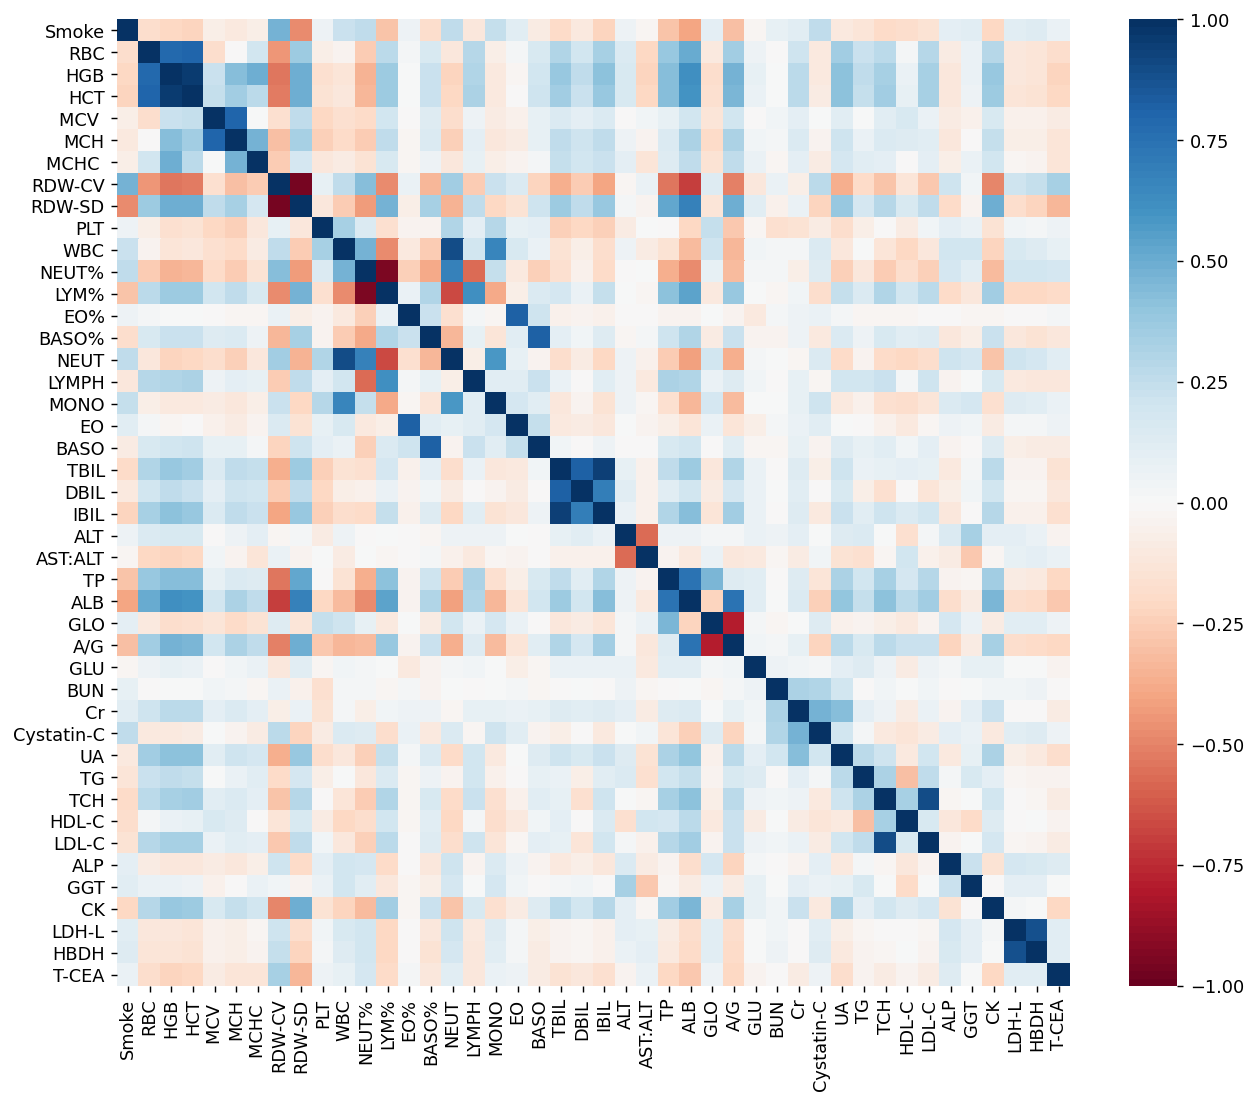

In [176]:
plt.figure(dpi=128, figsize = (12,10))
sns.heatmap(X.corr(), vmin = -1, vmax = 1, cmap=sns.color_palette('RdBu', n_colors=128))
plt.show()

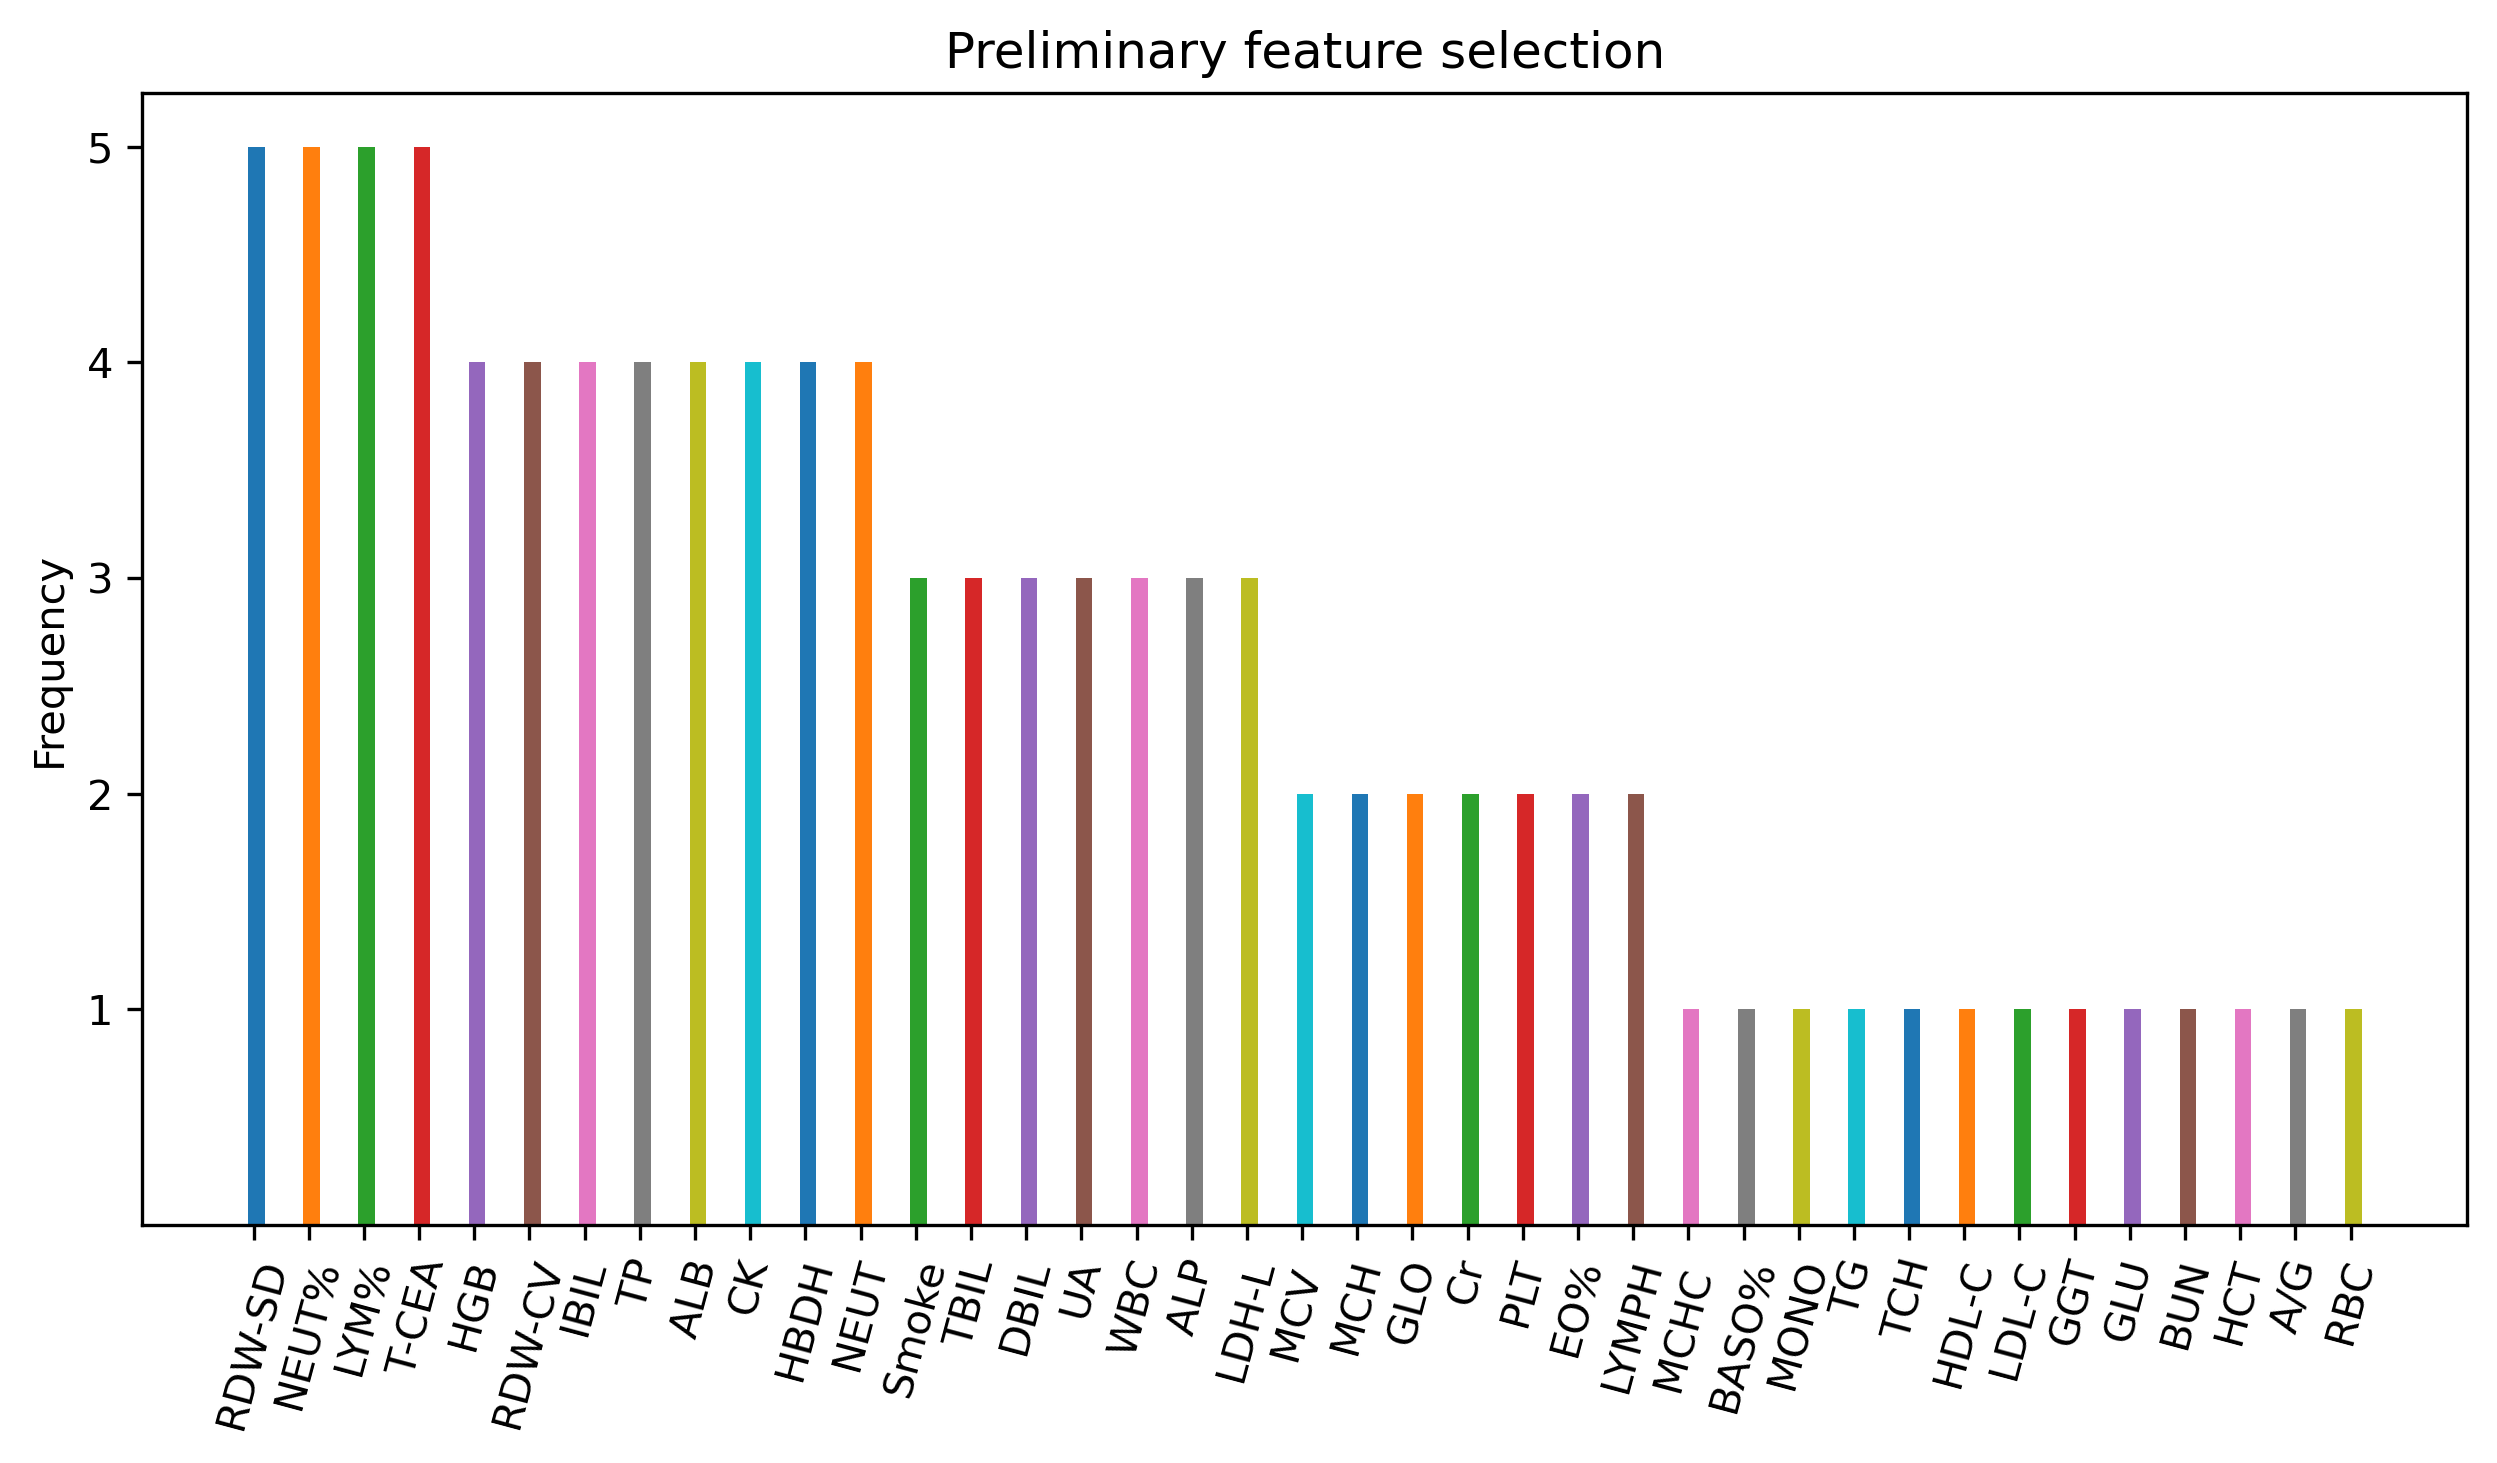

In [159]:
fea_stat = {}
for fea in [lr_fea, dt_fea, sv_fea, chi_fea, info_fea]:
    for i in fea:
        fea_stat[i] = fea_stat.get(i, 0)+1
fea_stat = {k:v for k,v in sorted(fea_stat.items(), key=lambda d: d[1], reverse=True) }

plt.figure(dpi=300, figsize = (10,5))
for i, key in enumerate(fea_stat):
    plt.bar(i, fea_stat[key], width=0.3)
plt.xticks(np.arange(len(fea_stat))-0.05, fea_stat.keys(), rotation=75)
# plt.xticks([])
plt.yticks([1,2,3,4,5])
plt.ylabel('Frequency')
plt.title('Preliminary feature selection')
plt.show()

## 移除一些相关性较低的特征，进行第二轮选择